In [ ]:
!pip install --quiet --upgrade pip
!pip install --quiet "jax[cuda11_cudnn82]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 75.6 MB/s eta 0:00:00


In [ ]:
import time
import csv
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

 Print out all devices; the first GPU (if present) is typically device 0.

In [ ]:
print("JAX devices:", jax.devices())

JAX devices: [CudaDevice(id=0)]


User-configurable dtype (choose from float32, float64, complex64, complex128)

In [ ]:
dtype_str = "complex64"  # Change this to desired dtype

Map dtype string to JAX and NumPy types

In [ ]:
jax_dtype = getattr(jnp, dtype_str)
np_dtype = getattr(np, dtype_str)

Device‐only SVD routine

In [ ]:
def batched_svd_on_device(batch_jax: jnp.ndarray):
    """
    Compute a batched SVD on a JAX array that's already on device.

    Args:
      batch_jax: a JAX array of shape (B, M, N), dtype=float32 or float64.
                  It should already reside on the accelerator (GPU/TPU).

    Returns:
      (U_j, S_j, Vh_j):
        U_j  has shape (B, M, K),
        S_j  has shape (B, K),
        Vh_j has shape (B, K, N),
      where K = min(M, N). All three are JAX arrays on device.
    """
    U_j, S_j, Vh_j = jnp.linalg.svd(batch_jax, full_matrices=False)
    return U_j, S_j, Vh_j

In [ ]:
def generate_random_batch(B, m, n):
    if np.dtype(np_dtype).kind == 'c':  # Complex dtype
        real_part = np.random.randn(B, m, n).astype(np_dtype(0).real.dtype)
        imag_part = np.random.randn(B, m, n).astype(np_dtype(0).real.dtype)
        return real_part + 1j * imag_part
    else:  # Real dtype
        return np.random.randn(B, m, n).astype(np_dtype)

Iterate over the batch size

In [ ]:
m = 4
n = 4
batch_sizes = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536]

# Warmup execution
print("Performing warmup execution...")
warmup_size = 32
warmup_batch = generate_random_batch(warmup_size, m, n)
warmup_jax = jnp.array(warmup_batch, dtype=jax_dtype)

# Run warmup and block on first output array
U_warm, _, _ = batched_svd_on_device(warmup_jax)
U_warm.block_until_ready()

elapsed_times = []
avg_errors = []

for B in batch_sizes:
    batch_cpu = generate_random_batch(B, m, n)
    batch_jax = jnp.array(batch_cpu, dtype=jax_dtype)

    jax.random.normal(jax.random.PRNGKey(0), ()).block_until_ready()

    t_start = time.perf_counter()
    U_j, S_j, Vh_j = batched_svd_on_device(batch_jax)
    U_j.block_until_ready()
    t_elapsed = time.perf_counter() - t_start
    elapsed_times.append(t_elapsed)

    U_cpu = np.array(U_j)
    S_cpu = np.array(S_j)
    Vh_cpu = np.array(Vh_j)

    errors = []
    for i in range(B):
        Ai = batch_cpu[i]
        Ui = U_cpu[i]
        Si = np.diag(S_cpu[i])
        Vhi = Vh_cpu[i]
        recon_i = Ui @ Si @ Vhi

        # Use absolute value for complex differences
        diff = np.abs(recon_i - Ai) if np.iscomplexobj(recon_i) else recon_i - Ai
        err = 100. * np.linalg.norm(diff) / np.linalg.norm(Ai)
        errors.append(err)

    avg_error = np.mean(errors)
    avg_errors.append(avg_error)
    print(f"Batch size B={B} | dtype={dtype_str} | time={t_elapsed:.6f}s | avg_rel_error (percentage)={avg_error:.3e}")

Performing warmup execution...
Batch size B=32 | dtype=complex64 | time=0.000771s | avg_rel_error (percentage)=1.103e-04
Batch size B=64 | dtype=complex64 | time=0.061077s | avg_rel_error (percentage)=9.298e-05
Batch size B=128 | dtype=complex64 | time=0.062593s | avg_rel_error (percentage)=9.856e-05
Batch size B=256 | dtype=complex64 | time=0.064928s | avg_rel_error (percentage)=1.006e-04
Batch size B=512 | dtype=complex64 | time=0.067327s | avg_rel_error (percentage)=9.835e-05
Batch size B=1024 | dtype=complex64 | time=0.067233s | avg_rel_error (percentage)=9.558e-05
Batch size B=2048 | dtype=complex64 | time=0.075627s | avg_rel_error (percentage)=9.781e-05
Batch size B=4096 | dtype=complex64 | time=0.091877s | avg_rel_error (percentage)=9.674e-05
Batch size B=8192 | dtype=complex64 | time=0.118191s | avg_rel_error (percentage)=9.690e-05
Batch size B=16384 | dtype=complex64 | time=0.165409s | avg_rel_error (percentage)=9.693e-05
Batch size B=32768 | dtype=complex64 | time=0.231298s |

Summary of errors and timings

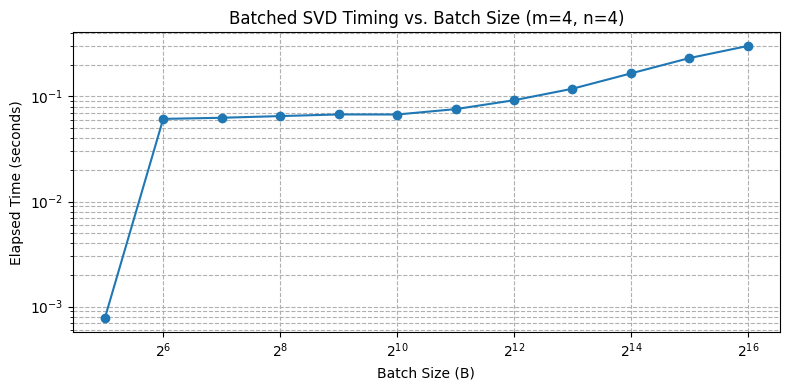

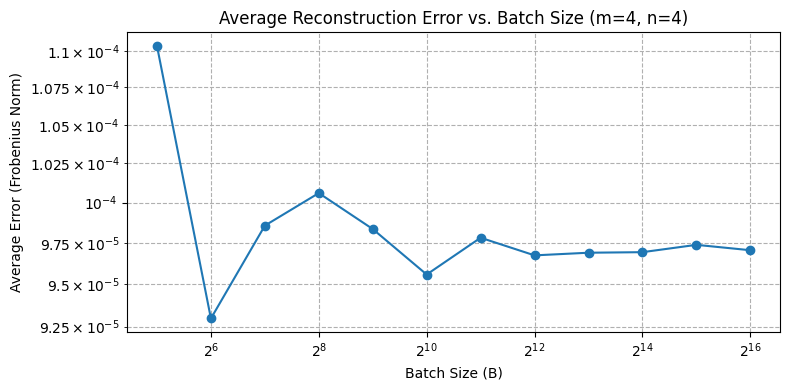

In [ ]:
B_array = np.array(batch_sizes)
elapsed_array = np.array(elapsed_times)
error_array = np.array(avg_errors)

# Plot Timing vs. Batch Size (log-log scale)
plt.figure(figsize=(8, 4))
plt.plot(B_array, elapsed_array, marker='o')
plt.title(f"Batched SVD Timing vs. Batch Size (m={m}, n={n})")
plt.xlabel("Batch Size (B)")
plt.ylabel("Elapsed Time (seconds)")
plt.xscale('log', base=2)
plt.yscale('log')
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()

# Plot Average Reconstruction Error vs. Batch Size (log-log scale)
plt.figure(figsize=(8, 4))
plt.plot(B_array, error_array, marker='o')
plt.title(f"Average Reconstruction Error vs. Batch Size (m={m}, n={n})")
plt.xlabel("Batch Size (B)")
plt.ylabel("Average Error (Frobenius Norm)")
plt.xscale('log', base=2)
plt.yscale('log')
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()

Saving the results

In [ ]:
# Save data to CSV
filename = "resultsJAX.csv"
with open(filename, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["elapsed_time", "error"])  # Header row
    writer.writerows(zip(elapsed_times, errors))

print(f"Data saved to {filename}")

Data saved to resultsJAX.csv
